# Forecasting with RNN

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import config
print(tf.__version__)

tf.compat.v1.keras.backend.set_session(config.SESS)

1 Physical GPUs, 1 Logical GPUs
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080, pci bus id: 0000:01:00.0, compute capability: 7.5

2.3.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Defining the network model (with lambda layers for pre/post processing) and search optimal learning rate

In [4]:
# tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 0s 15ms/step - loss: 195.5726 - mae: 196.0726
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 194.7820 - mae: 195.2820
Epoch 3/100
8/8 [==============================] - 0s 13ms/step - loss: 193.5109 - mae: 194.0109
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 191.9080 - mae: 192.4080
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 190.0235 - mae: 190.5235
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 187.8582 - mae: 188.3582
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 185.3786 - mae: 185.8786
Epoch 8/100
8/8 [==============================] - 0s 13ms/step - loss: 182.5483 - mae: 183.0483
Epoch 9/100
8/8 [==============================] - 0s 12ms/step - loss: 179.3126 - mae: 179.8126
Epoch 10/100
8/8 [==============================] - 0s 13ms/step - loss: 175.6017 - mae: 176.1017
Epoch 11/100
8/8 [===========

Epoch 87/100
8/8 [==============================] - 0s 12ms/step - loss: 19.1021 - mae: 19.5977
Epoch 88/100
8/8 [==============================] - 0s 12ms/step - loss: 22.1847 - mae: 22.6786
Epoch 89/100
8/8 [==============================] - 0s 12ms/step - loss: 16.8389 - mae: 17.3326
Epoch 90/100
8/8 [==============================] - 0s 12ms/step - loss: 33.3735 - mae: 33.8714
Epoch 91/100
8/8 [==============================] - 0s 12ms/step - loss: 33.3506 - mae: 33.8482
Epoch 92/100
8/8 [==============================] - 0s 12ms/step - loss: 36.5549 - mae: 37.0524
Epoch 93/100
8/8 [==============================] - 0s 12ms/step - loss: 37.2290 - mae: 37.7283
Epoch 94/100
8/8 [==============================] - 0s 13ms/step - loss: 42.6305 - mae: 43.1297
Epoch 95/100
8/8 [==============================] - 0s 14ms/step - loss: 49.3588 - mae: 49.8580
Epoch 96/100
8/8 [==============================] - 0s 12ms/step - loss: 61.6840 - mae: 62.1837
Epoch 97/100
8/8 [======================

(1e-08, 0.0001, 0.0, 30.0)

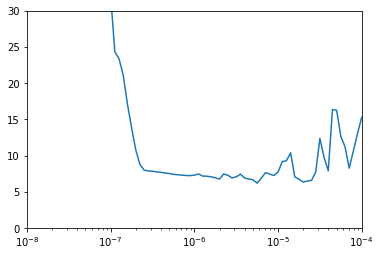

In [5]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [6]:
tf.keras.backend.clear_session()
tf.compat.v1.keras.backend.set_session(config.SESS)
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.SimpleRNN(40, return_sequences=True),
  tf.keras.layers.SimpleRNN(40),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=400)

Epoch 1/400
8/8 [==============================] - 0s 12ms/step - loss: 81.7535 - mae: 82.2534
Epoch 2/400
8/8 [==============================] - 0s 12ms/step - loss: 21.9357 - mae: 22.4301
Epoch 3/400
8/8 [==============================] - 0s 12ms/step - loss: 15.9200 - mae: 16.4143
Epoch 4/400
8/8 [==============================] - 0s 12ms/step - loss: 12.2878 - mae: 12.7813
Epoch 5/400
8/8 [==============================] - 0s 12ms/step - loss: 10.1493 - mae: 10.6395
Epoch 6/400
8/8 [==============================] - 0s 12ms/step - loss: 16.3994 - mae: 16.8944
Epoch 7/400
8/8 [==============================] - 0s 12ms/step - loss: 13.2552 - mae: 13.7462
Epoch 8/400
8/8 [==============================] - 0s 12ms/step - loss: 9.1545 - mae: 9.6428
Epoch 9/400
8/8 [==============================] - 0s 13ms/step - loss: 6.9726 - mae: 7.4610
Epoch 10/400
8/8 [==============================] - 0s 12ms/step - loss: 10.5557 - mae: 11.0499
Epoch 11/400
8/8 [==============================] - 0

Epoch 88/400
8/8 [==============================] - 0s 12ms/step - loss: 4.8396 - mae: 5.3175
Epoch 89/400
8/8 [==============================] - 0s 12ms/step - loss: 4.5359 - mae: 5.0105
Epoch 90/400
8/8 [==============================] - 0s 12ms/step - loss: 4.8868 - mae: 5.3691
Epoch 91/400
8/8 [==============================] - 0s 12ms/step - loss: 5.0816 - mae: 5.5603
Epoch 92/400
8/8 [==============================] - 0s 11ms/step - loss: 5.2164 - mae: 5.6979
Epoch 93/400
8/8 [==============================] - 0s 12ms/step - loss: 6.0816 - mae: 6.5646
Epoch 94/400
8/8 [==============================] - 0s 12ms/step - loss: 5.5219 - mae: 6.0044
Epoch 95/400
8/8 [==============================] - 0s 12ms/step - loss: 5.2777 - mae: 5.7589
Epoch 96/400
8/8 [==============================] - 0s 12ms/step - loss: 6.7643 - mae: 7.2492
Epoch 97/400
8/8 [==============================] - 0s 13ms/step - loss: 8.8255 - mae: 9.3148
Epoch 98/400
8/8 [==============================] - 0s 13ms/

8/8 [==============================] - 0s 12ms/step - loss: 4.5083 - mae: 4.9830
Epoch 175/400
8/8 [==============================] - 0s 12ms/step - loss: 4.5727 - mae: 5.0492
Epoch 176/400
8/8 [==============================] - 0s 12ms/step - loss: 4.5858 - mae: 5.0647
Epoch 177/400
8/8 [==============================] - 0s 12ms/step - loss: 4.3588 - mae: 4.8373
Epoch 178/400
8/8 [==============================] - 0s 12ms/step - loss: 4.6424 - mae: 5.1195
Epoch 179/400
8/8 [==============================] - 0s 11ms/step - loss: 5.0409 - mae: 5.5165
Epoch 180/400
8/8 [==============================] - 0s 12ms/step - loss: 5.4680 - mae: 5.9491
Epoch 181/400
8/8 [==============================] - 0s 12ms/step - loss: 4.7668 - mae: 5.2429
Epoch 182/400
8/8 [==============================] - 0s 13ms/step - loss: 4.4382 - mae: 4.9178
Epoch 183/400
8/8 [==============================] - 0s 12ms/step - loss: 4.9436 - mae: 5.4218
Epoch 184/400
8/8 [==============================] - 0s 12ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 4.6767 - mae: 5.1549
Epoch 261/400
8/8 [==============================] - 0s 12ms/step - loss: 5.1270 - mae: 5.6065
Epoch 262/400
8/8 [==============================] - 0s 12ms/step - loss: 4.4300 - mae: 4.9080
Epoch 263/400
8/8 [==============================] - 0s 12ms/step - loss: 4.7091 - mae: 5.1873
Epoch 264/400
8/8 [==============================] - 0s 12ms/step - loss: 5.1522 - mae: 5.6309
Epoch 265/400
8/8 [==============================] - 0s 12ms/step - loss: 5.0958 - mae: 5.5738
Epoch 266/400
8/8 [==============================] - 0s 12ms/step - loss: 4.5118 - mae: 4.9854
Epoch 267/400
8/8 [==============================] - 0s 13ms/step - loss: 4.2658 - mae: 4.7396
Epoch 268/400
8/8 [==============================] - 0s 13ms/step - loss: 4.7516 - mae: 5.2300
Epoch 269/400
8/8 [==============================] - 0s 12ms/step - loss: 4.4758 - mae: 4.9519
Epoch 270/400
8/8 [==============================] - 0s 13ms/ste

8/8 [==============================] - 0s 12ms/step - loss: 4.4805 - mae: 4.9579
Epoch 347/400
8/8 [==============================] - 0s 12ms/step - loss: 5.2553 - mae: 5.7390
Epoch 348/400
8/8 [==============================] - 0s 12ms/step - loss: 5.3597 - mae: 5.8423
Epoch 349/400
8/8 [==============================] - 0s 12ms/step - loss: 4.9383 - mae: 5.4158
Epoch 350/400
8/8 [==============================] - 0s 12ms/step - loss: 4.4054 - mae: 4.8838
Epoch 351/400
8/8 [==============================] - 0s 12ms/step - loss: 4.6026 - mae: 5.0787
Epoch 352/400
8/8 [==============================] - 0s 12ms/step - loss: 4.3677 - mae: 4.8435
Epoch 353/400
8/8 [==============================] - 0s 12ms/step - loss: 4.2031 - mae: 4.6807
Epoch 354/400
8/8 [==============================] - 0s 11ms/step - loss: 4.4967 - mae: 4.9743
Epoch 355/400
8/8 [==============================] - 0s 11ms/step - loss: 5.8632 - mae: 6.3423
Epoch 356/400
8/8 [==============================] - 0s 12ms/ste

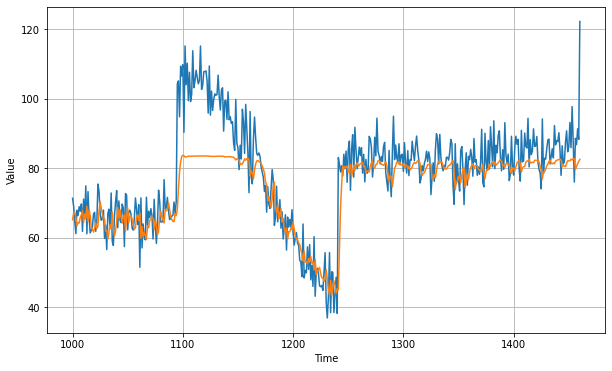

In [7]:
forecast=[]
for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [8]:
print('MAE: ',tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

MAE:  6.674485


#

<Figure size 432x288 with 0 Axes>

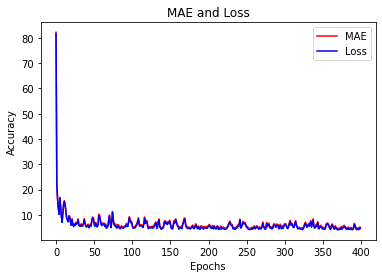

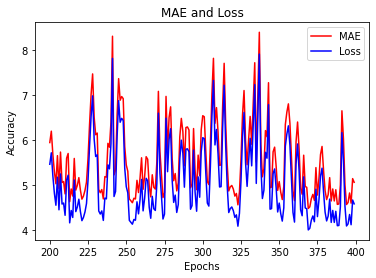

<Figure size 432x288 with 0 Axes>

In [9]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()